# Lab exercises 3 - Eva Agrawal & Robin de Groot Part 2

For this lab exercises, please submit 2 notebooks / python script and 2 reports, one for each part. The deadline is 22 december.

It is important the you **read the documentation** to understand how to use Pytorch functions, what kind of transformation they apply etc. You have to **take time to read it carefully** to understand what you are doing.

- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/torch.html


The following libraries are necessary for this assignment.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

sns.set()

import dataset_loader

%matplotlib inline

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [4]:
train_img = train_data[0]
train_label = train_data[1]
dev_img = dev_data[0]
dev_label = dev_data[1]
test_img = test_data[0]
test_label = test_data[1]

In [5]:
train_img[1].shape

(784,)

In [68]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)

## Part 2: Variational Auto-Encoder

To build a new Variational Auto-Encoder, you need two networks:

- An encoder that will take as input an image and compute the parameters of list of Normal distributions
- A decoder that will take a sample from each Normal distribution and will output an image

For simplicity we will assume that:

- each network as a single hidden layer of size 100
- the latent space contains only 2 points

To understand exactly what a VAE is, you can:

- check the slides of Michèle Sebag
- check this tutorial: https://arxiv.org/abs/1606.05908


### 2.1. Encoder

- Compute an hidden representation: $z=relu(W^1x+b^1)$
- Compute the means of the normal distributions: $mu=W^2x+b^2$
- Compute the log variance of the normal distributions: $log\_sigma\_squared=W^3x+b^3$

### 2.2. Decoder

This a simple MLP, nothing new here!

### 1.3. Training loss

To compute the training loss, you must compute two terms:

- a Monte-Carlo estimation of the reconstruction loss
- the KL divergence between the distributions computed by the encoder and the prior

To sample values, you can use the reparameterization trick as follows:

https://graviraja.github.io/vanillavae/#
https://github.com/atinghosh/VAE-pytorch
https://github.com/pytorch/examples/blob/master/vae/main.py
https://github.com/altosaar/variational-autoencoder/blob/master/train_variational_autoencoder_pytorch.py
https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
https://arxiv.org/pdf/1606.05908.pdf

In [0]:
class VAE(nn.Module):
    def __init__(self, input_dim, layer_dim, latent_dim):
        super(VAE, self).__init__()
        enc_layers = []
        enc_layers.append(nn.Linear(input_dim, layer_dim))
        enc_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*enc_layers)
        
        self.mu_layer = nn.Linear(layer_dim, latent_dim)
        self.logvar_layer = nn.Linear(layer_dim, latent_dim)
        
        dec_layers = []
        dec_layers.append(nn.Linear(latent_dim, layer_dim))
        dec_layers.append(nn.ReLU())
        dec_layers.append(nn.Linear(layer_dim, input_dim))
        dec_layers.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*dec_layers)

    def encode(self, x):
        h1 = self.encoder(x)
        return self.mu_layer(h1), self.logvar_layer(h1)
    
    def reparameterization(self, mu, logvar):
        stddev = torch.exp(0.5*logvar)
        e = torch.randn_like(stddev)
        return mu + e*stddev
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterization(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
def loss_function(output, x_orig, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(output, x_orig.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [0]:
def training(model,
            train_images,
            loss_function,
            optimizer,
            dev_images,
            n_epochs,
            batch_size):
    
    loss_list = []
    test_loss_list = []
            
    for epoch in range(n_epochs):
        print('Starting epoch: {}'.format(epoch))
        cost = 0
        model.train()

        for first in range(0, len(train_images), batch_size):
            optimizer.zero_grad()
            
            batch_input = torch.cat(
                [
                    torch.from_numpy(image).reshape(1, -1)
                    for image in train_images[first:first + batch_size]
                    
                ],
                    dim=0
            ).to(device)
            batch_output, mu, logvar = model(batch_input)            
            
            loss = loss_function(batch_output, batch_input, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5.)
            cost += loss.item()
            optimizer.step()
            
        mean_loss = (cost//batch_size+1) / len(train_images)
        print('mean loss: ', mean_loss)
        
        loss_list.append(mean_loss)

        test_loss = testing(model,
                            loss_function,
                            optimizer,
                            dev_images,
                            n_epochs,
                            batch_size)
        test_loss_list.append(test_loss)
    
    return model, loss_list, test_loss_list

In [0]:
def testing(model,
            loss_function,
            optimizer,
            dev_images,
            n_epochs,
            batch_size):
    
    model.eval()
    loss = 0
            
    for first in range(0, len(dev_images), batch_size):
        optimizer.zero_grad()
        
        batch_input = torch.cat(
            [
                torch.from_numpy(image).reshape(1, -1)
                for image in dev_images[first:first + batch_size]
                
            ],
                dim=0
        ).to(device)
        batch_output, mu, logvar = model(batch_input)            
        
        loss += loss_function(batch_output, batch_input, mu, logvar).item()
        
    test_loss = (loss//batch_size+1) / len(dev_images)
    print('mean test loss: ', test_loss)
        
    return test_loss

In [31]:
input_dim = len(train_img[0])
layer_dim = 100
latent_dim = 2
models_list_VAE = []
mean_loss_list_VAE = []
test_mean_loss_list_VAE = []

EPOCHS = 50
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim, layer_dim, latent_dim)
model.apply(init_weights)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
VAE_model, mean_losses, test_loss_list = training(model, train_img, loss_function, optimizer, dev_img, EPOCHS, batch_size)
models_list_VAE.append(VAE_model)
mean_loss_list_VAE.append(mean_losses)

#plot_graphs(mean_loss_list, dev_accuracy_list, dropout_value, layerdim, lr, batch_size, "Tanh")

Starting epoch: 0
mean loss:  1.70412
mean test loss:  1.4154
Starting epoch: 1
mean loss:  1.37732
mean test loss:  1.3367
Starting epoch: 2
mean loss:  1.33062
mean test loss:  1.3129
Starting epoch: 3
mean loss:  1.31398
mean test loss:  1.302
Starting epoch: 4
mean loss:  1.30276
mean test loss:  1.2907
Starting epoch: 5
mean loss:  1.29422
mean test loss:  1.2847
Starting epoch: 6
mean loss:  1.28764
mean test loss:  1.2769
Starting epoch: 7
mean loss:  1.2811
mean test loss:  1.2707
Starting epoch: 8
mean loss:  1.27536
mean test loss:  1.2652
Starting epoch: 9
mean loss:  1.26972
mean test loss:  1.2637
Starting epoch: 10
mean loss:  1.26524
mean test loss:  1.2534
Starting epoch: 11
mean loss:  1.26122
mean test loss:  1.2552
Starting epoch: 12
mean loss:  1.2567
mean test loss:  1.2507
Starting epoch: 13
mean loss:  1.25288
mean test loss:  1.2456
Starting epoch: 14
mean loss:  1.24934
mean test loss:  1.2422
Starting epoch: 15
mean loss:  1.24606
mean test loss:  1.2375
Start

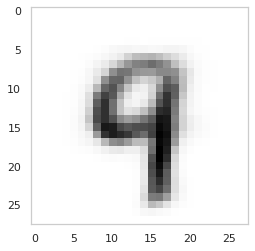

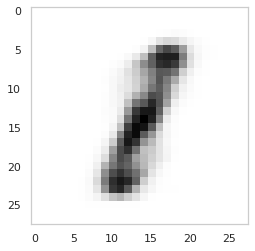

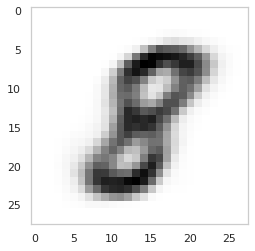

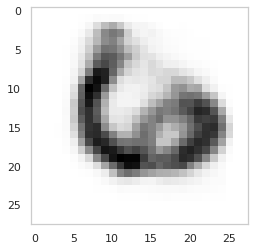

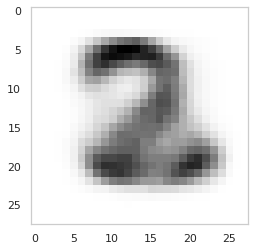

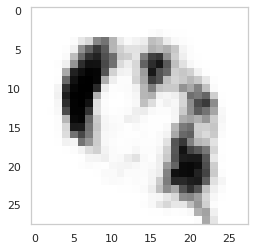

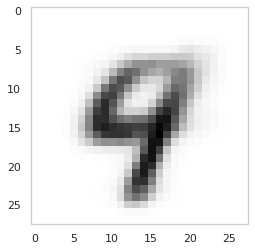

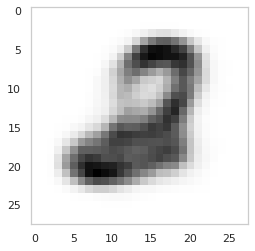

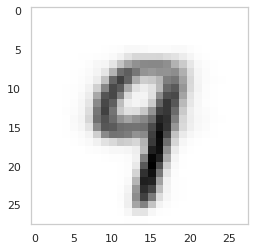

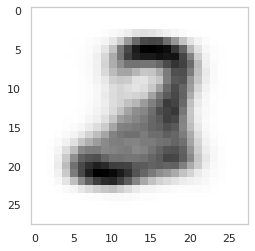

In [39]:
e = torch.normal(0, 1., (10, 2)).to(device)
images = model.decode(e)

for i in range(10):
    picture = images[i].clone().detach().cpu().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()